# <p style="background-color:#063d91;color:white;font-size:90%;text-align:center;border-radius:5px 5px;height:40px;padding-top: 5px;"> ⚙️Bearing Fault Diagnosis using Acoustic Emissions</p>

In [152]:
# imports
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers, Model

import matplotlib.pyplot as plt

### About the data

The dataset contains vibration signals collected from bearings under time-varying  
rotational speed conditions from the University of Ottawa. It consists in 4 audios  
of 12 seconds each of the different engines.

The recording sampling rate is 10 kHz.


The dataset is publicly available on kaggle.  

In [153]:
FS = 10000

## load data
data = loadmat('data\dataset.mat\dataset.mat')

## extract different failure types
normal = np.squeeze(data['normal'])
inner = np.squeeze(data['inner'])
outer = np.squeeze(data['outer'])
roller = np.squeeze(data['roller'])

### Visualize data

In [154]:
def visualize_data(
    data: tuple,
    fault_types: tuple,
    n_values: int
) -> None:

    
    # generate x axis
    x_time = np.arange(0, n_values * 1/FS, 1/FS)
    
    plt.figure(figsize=(6,3))
    
    for idx, element in enumerate(data):
        plt.plot(x_time, element[:n_values], label=fault_types[idx])
    
    plt.ylabel('Accelaration m/s²')
    plt.xlabel('Time [s]')
    plt.title('Different fault types in comparison')
    plt.grid()
    plt.legend()
    
    plt.show()

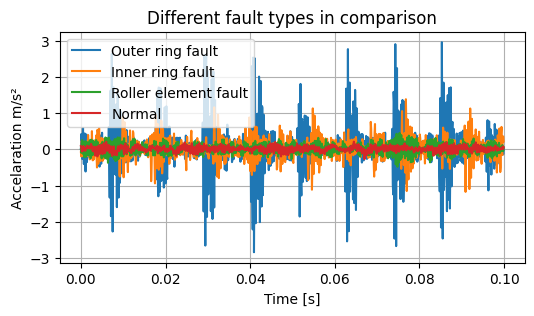

In [155]:
visualize_data(
    (outer, inner, roller, normal),
    ('Outer ring fault', 'Inner ring fault', 'Roller element fault', 'Normal'),
    1000
)

From the plotted signals above it is clear, that the present diagnosis task is not  
of high difficulty, since the different failures are clearly distinguishable in  
the plot.  
Nevertheless different diagnosis methods are demonstrated within this project.  
It is expected to result in really accurate failure diagnosis.


### Prepare data

In other to a classify the health condition of a bearing, we import the data and  
create instances from them. The idea is to separate the signal of a condition into  
batches of data that will be processed and have their feature extracted.  
In this nb no overlap is used since the problem appears to be relatively modest  
to solve. 

In [156]:
def window_data(
    data: np.ndarray,
    instances: int,
) -> np.ndarray:

    try: 
        windowed = np.split(data, instances)
    
    except:
        print('Please choose an appropriate number of instances. \n \
            (Has to be an exact divider of 120000) ') 
    
    return np.array(windowed)

In [157]:
# window data in n instances to have more effective samples available
# generate also the respective labels hereby
n_instances = 60

data = []
labels= []

for idx, element in enumerate([normal, inner, outer, roller]):
    
    windowed = window_data(
        element, 
        n_instances
    )
    
    data.append(windowed)
    
    category = np.ones((windowed.shape[0], )) * idx
    
    labels.append(category)
        
data = np.vstack(data)
labels = np.hstack((labels))

**Visualize windowed data**

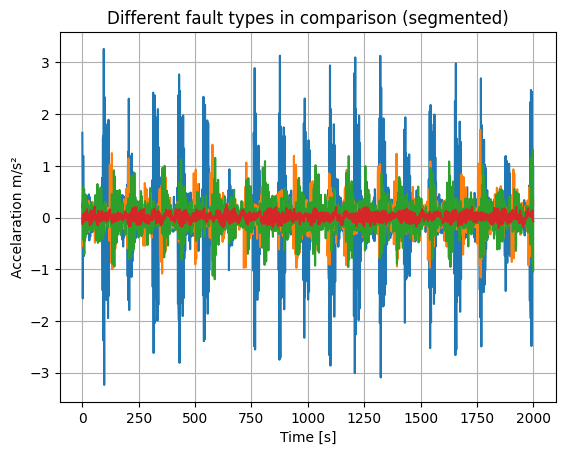

In [158]:
for i in range(4, 0, -1):
    plt.plot(data[35 * i])

plt.ylabel('Accelaration m/s²')
plt.xlabel('Time [s]')
plt.title('Different fault types in comparison (segmented)')
plt.grid()
plt.show()

**Split data in train and test set**

In [159]:
x_train, x_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size=0.2
)

x_train = np.expand_dims(x_train, (-1))
x_test = np.expand_dims(x_test, (-1))

**Scale data**

In [160]:
# ...

### Neural network classification of the different faults

In [161]:
def build_model(
    window_length: int,
    n_features: int,
    n_classes: int=4
) -> Model:
    
    input_data = layers.Input(shape=(window_length, n_features))
    
    x = layers.Conv1D(filters=16, kernel_size=16, padding='same')(input_data)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=32, kernel_size=5, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(units=100, activation='relu')(x)
    x = layers.Dropout(rate=0.3)(x)
    
    
    
    out = layers.Dense(units=n_classes, activation='softmax')(x)
    
    
    model = Model(
        inputs=[input_data],
        outputs=[out]
    )
    
    opt = tf.optimizers.Adam(
        lr=0.0002, 
        beta_1=0.9
    )
    
    model.compile(
        loss=['sparse_categorical_crossentropy'],
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    
    return model

In [162]:
model = build_model(
    x_train.shape[1],
    x_train.shape[2],
)

c:\Users\pnmue\anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


- vhoose low batch size since not many samples

In [163]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=2
)

Epoch 1/10
96/96 [==============================] - 2s 13ms/step - loss: 1.8586 - sparse_categorical_accuracy: 0.3646 - val_loss: 1.6953 - val_sparse_categorical_accuracy: 0.2708
Epoch 2/10
96/96 [==============================] - 1s 12ms/step - loss: 0.7980 - sparse_categorical_accuracy: 0.7135 - val_loss: 2.3838 - val_sparse_categorical_accuracy: 0.2708
Epoch 3/10
96/96 [==============================] - 1s 12ms/step - loss: 0.5539 - sparse_categorical_accuracy: 0.7812 - val_loss: 2.4103 - val_sparse_categorical_accuracy: 0.2708
Epoch 4/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3777 - sparse_categorical_accuracy: 0.8802 - val_loss: 1.1456 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
96/96 [==============================] - 1s 12ms/step - loss: 0.3123 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.2790 - val_sparse_categorical_accuracy: 0.9583
Epoch 6/10
96/96 [==============================] - 1s 12ms/step - loss: 0.2682 - sparse_categorical_accu

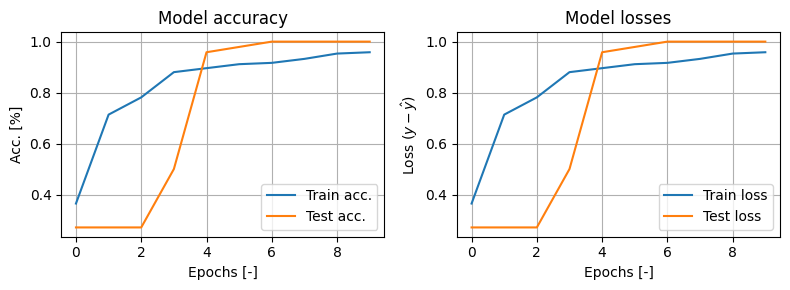

In [164]:
## plot history

fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].plot(history.history['sparse_categorical_accuracy'], label='Train acc.')
axs[0].plot(history.history['val_sparse_categorical_accuracy'], label='Test acc.')
axs[0].set_ylabel('Acc. [%]')
axs[0].set_xlabel('Epochs [-]')
axs[0].set_title('Model accuracy')
axs[0].legend()
axs[0].grid()

axs[1].plot(history.history['sparse_categorical_accuracy'], label='Train loss')
axs[1].plot(history.history['val_sparse_categorical_accuracy'], label='Test loss')
axs[1].set_ylabel('Loss $(y-\hat{y})$')
axs[1].set_xlabel('Epochs [-]')
axs[1].set_title('Model losses')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Visualize decision in "live" system when using trained model

In [165]:
def order_indices(
    y_train,
    labels=[0, 1, 2, 3]
):
    
    class_indices = []
    
    for label in labels:
        class_indices.append(np.where(y_train == label))
    
    return class_indices

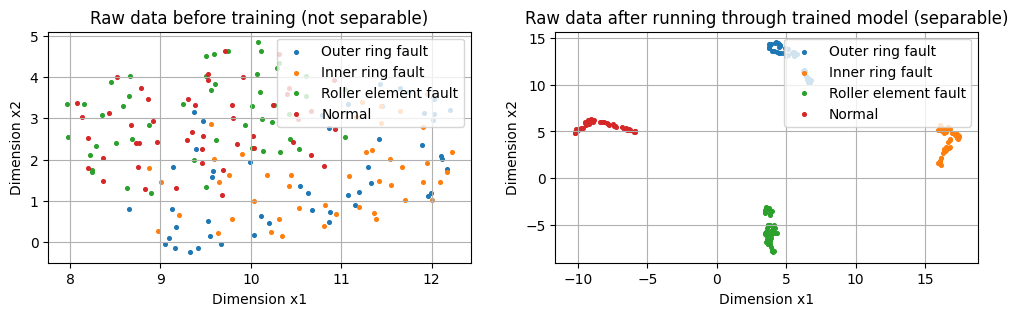

In [167]:
## visualize feature space
import umap


fig, axs = plt.subplots(1, 2, figsize=(12,3))

classes = order_indices(y_train)
labels = ('Outer ring fault', 'Inner ring fault', 'Roller element fault', 'Normal')


features = umap.UMAP(
    n_neighbors=10
).fit(np.squeeze(x_train))

for i in range(len(classes)):
    axs[0].scatter(features.embedding_[classes[i]][:, 0], features.embedding_[classes[i]][:, 1], s=7, label=labels[i])
axs[0].set_xlabel('Dimension x1')
axs[0].set_ylabel('Dimension x2')
axs[0].set_title('Raw data before training (not separable)')
axs[0].legend(loc='upper right')
axs[0].grid()


features = umap.UMAP(
    n_neighbors=10
).fit(np.squeeze(model(x_train)))

for i in range(len(classes)):
    axs[1].scatter(features.embedding_[classes[i]][:, 0], features.embedding_[classes[i]][:, 1], s=7, label=labels[i])
axs[1].set_xlabel('Dimension x1')
axs[1].set_ylabel('Dimension x2')
axs[1].set_title('Raw data after running through trained model (separable)')
axs[1].legend(loc='upper right')
axs[1].grid()

plt.show()


### Visualize important regions in the signals

... explain integrated gradients ... 